# Modules imports

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import cv2

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # ignore TF unsupported NUMA warnings

# Filter out TFA warning
#import warnings
#warnings.filterwarnings("ignore", message="TFA has entered a minimal maintenance and release mode", category=Warning)

import tensorflow as tf
import tensorflow_addons as tfa


# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
   tf.config.experimental.set_memory_growth(gpu, True)


/home/jacopo/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Hyperparameters

In [2]:
BATCH_SIZE = 3

# Importing dataset

In [3]:
print("Started dataset loading...")

input_path = "/mnt/c/Users/jacop/Desktop/DL_Project/processed_dataset/" #if in wsl
#input_path = "/mnt/c/Users/vitto/Desktop/DL project/DL project github/processed_dataset/" #if in wsl
#input_path = r"C:\Users\vitto\Desktop\DL project\DL project github\processed_dataset"  # if in windows
#input_path = r"C:\Users\jacop\Desktop\DL_Project\processed_dataset"  # if in windows



# Definizione della funzione per l'elaborazione delle immagini
def process_image(x):
    # Leggi il contenuto del file immagine come sequenza di byte
    byte_img = tf.io.read_file(x)
    # Decodifica l'immagine utilizzando il formato JPEG
    img = tf.io.decode_jpeg(byte_img)
    # Convert images to grayscale
    img = tf.image.rgb_to_grayscale(img)
    img = tf.squeeze(img, axis=-1)
    # Normalizza i valori dei pixel nell'intervallo [0, 1]
    img = img / 255
    return img


# Creazione di un dataset per le immagini di addestramento
train_images = tf.data.Dataset.list_files(
    input_path + "/images/train/*.jpg", shuffle=False
)
# Applica la funzione process_image a ciascun elemento del dataset
train_images = train_images.map(process_image)

# Creazione di un dataset per le immagini di test
test_images = tf.data.Dataset.list_files(
    input_path + "/images/test/*.jpg", shuffle=False
)
# Applica la funzione process_image a ciascun elemento del dataset
test_images = test_images.map(process_image)

# Creazione di un dataset per le immagini di validazione
val_images = tf.data.Dataset.list_files(input_path + "/images/val/*.jpg", shuffle=False)
# Applica la funzione process_image a ciascun elemento del dataset
val_images = val_images.map(process_image)


# =========== Labels =========== #


# Definizione di una funzione per caricare le etichette da un file di testo
def load_labels(path):
    # Inizializza una lista vuota per le etichette
    landmarks = []

    # Apre il file di etichette specificato da `path` in modalità di lettura con encoding "utf-8"
    with open(path.numpy(), "r", encoding="utf-8") as file:
        # Salta la prima riga del file
        next(file, None)

        # Itera attraverso le righe rimanenti nel file
        for line in file:
            # Divide ciascuna riga in colonne utilizzando il carattere di tabulazione '\t' come delimitatore
            columns = line.strip().split("\t")

            # Estrae i valori X e Y dalle colonne 1 e 2 (considerando gli indici 0-based)
            # e li converte in valori float. Inoltre, li normalizza dividendo per 256
            x_value = float(columns[1]) / 256
            y_value = float(columns[2]) / 256

            # Aggiunge i valori X e Y normalizzati alla lista `landmarks`
            landmarks.extend([x_value, y_value])

    # Convert `landmarks` to a NumPy array
    return np.array(landmarks)


# Create train, test and val label dataset and load their labels using the corresponding function
train_labels = tf.data.Dataset.list_files(input_path + "/labels/train/*.txt", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files(input_path + "/labels/test/*.txt", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files(input_path + "/labels/val/*.txt", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))


# =========== Combine Images and Labels =========== #

# Creazione del dataset di addestramento combinando immagini ed etichette
train_dataset = tf.data.Dataset.zip((train_images, train_labels))
test_dataset = tf.data.Dataset.zip((test_images, test_labels))
val_dataset = tf.data.Dataset.zip((val_images, val_labels))

Started dataset loading...


# U-Net

Creating generators

In [4]:
print("Started U-Net training...")
 
# We only need images in this part
train_images_only = train_dataset.map(lambda img, lbl: img)
test_images_only = test_dataset.map(lambda img, lbl: img)
val_images_only = val_dataset.map(lambda img, lbl: img)


train_list = list(train_images_only)
val_list = list(val_images_only)

fixed_image = train_list[2]

def train_image_generator():
    for moving_image in train_list:

        # Combine fixed and moving images into a single tensor
        combined_image = tf.stack([fixed_image,moving_image],-1)
        yield (combined_image, fixed_image)


# Create a TensorFlow dataset from the generator
train_images_dataset = tf.data.Dataset.from_generator(
    train_image_generator,
    output_signature=(tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(256, 256), dtype=tf.float32))
    )
train_images_dataset = train_images_dataset.shuffle(1000).batch(BATCH_SIZE)

val_list = list(val_images_only)



# Create a generator function to yield the combined image tensor for validation
def val_image_generator():
    for moving_image in val_list:
        
        combined_image = tf.stack([fixed_image, moving_image], -1)
        yield (combined_image, fixed_image)

# Create a TensorFlow dataset from the generator for validation
val_images_dataset = tf.data.Dataset.from_generator(
    val_image_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256), dtype=tf.float32)
    )
)

# No need to shuffle for the validation set
val_images_dataset = val_images_dataset.batch(BATCH_SIZE)

Started U-Net training...


U-net architecture

In [ ]:
input_shape = (256, 256, 2)


# Due immagini, una fixed e una moving, prese come input
input = tf.keras.layers.Input(shape=input_shape)

### Downsampling path ###

# Applicazione della funzione di attivazione Leaky ReLU con coefficiente alpha
a1 = tf.keras.layers.LeakyReLU(alpha=0.01)(input)

# Applicazione di un layer di convoluzione 2D con 64 filtri di dimensione 3x3
c1 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal")(a1)

# Appli#cazione del layer di Dropout con un tasso di dropout del 10%
c1 = tf.keras.layers.Dropout(0.1)(c1)

# Applicazione del max-pooling con una finestra di pooling di dimensione 2x2
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)


a2 = tf.keras.layers.LeakyReLU(alpha=0.01)(p1)
c2 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(a2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)

a3 = tf.keras.layers.LeakyReLU(alpha=0.01)(p2)
c3 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

a4 = tf.keras.layers.LeakyReLU(alpha=0.01)(p3)
c4 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal")(a4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

a5 = tf.keras.layers.LeakyReLU(alpha=0.01)(p4)
c5 = tf.keras.layers.Conv2D(1024, 3, padding="same", kernel_initializer="he_normal")(a5)
c5 = tf.keras.layers.Dropout(0.3)(c5)

### Upsampling path ###

# Decodifica dell'output dell'encoder con la trasposizione della convoluzione 2D
u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = tf.keras.layers.concatenate(
    [u6, c4]
)  # Concatenazione dell'output con gli strati dell'encoder precedenti
a6 = tf.keras.layers.LeakyReLU(alpha=0.01)(u6)  # Applicazione di Leaky ReLU
c6 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal")(
    a6
)  # Convoluzione 2D
c6 = tf.keras.layers.Dropout(0.3)(c6)  # Applicazione di Dropout

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
a7 = tf.keras.layers.LeakyReLU(alpha=0.01)(u7)
c7 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a7)
c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
a8 = tf.keras.layers.LeakyReLU(alpha=0.01)(u8)
c8 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(a8)
c8 = tf.keras.layers.Dropout(0.2)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
a9 = tf.keras.layers.LeakyReLU(alpha=0.01)(u9)
c9 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal")(a9)
c9 = tf.keras.layers.Dropout(0.1)(c9)

# Creazione dell'output finale del modello
c10 = tf.keras.layers.Conv2D(2, 1, padding="same", kernel_initializer="he_normal")(c9)

# Creazione di un tensore di deformazione
displacement_tensor = tf.keras.layers.Conv2D(
    2, kernel_size=3,activation='linear', padding="same", name="disp"
)(c10)

# Define the function to extract the "bottom" tensor
def extract_moving_img(input):
    return input[:, :, :, 1:2]

moving_image = tf.keras.layers.Lambda(extract_moving_img)(input)

# Creazione di una funzione per applicare la trasformazione di deformazione all'immagine di input
def apply_deformation(inputs):
    #unpacking dell'input
    image, displacement_tensor = inputs
    # Applica la trasformazione di deformazione all'immagine di input utilizzando il tensore di deformazione
    deformed_image = tfa.image.dense_image_warp(image, displacement_tensor)
    return deformed_image
def_image = tf.keras.layers.Lambda(apply_deformation)([moving_image,displacement_tensor])

output = def_image

Model Initialization

In [57]:
# Create the U-Net model
unet = tf.keras.Model(inputs=input, outputs=output)

def custom_mse_loss(y_true, y_pred):
    # Calcola l'errore quadratico medio tra i tensori y_true e y_pred
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse


# Compile the model with the custom loss
unet.compile(optimizer='adam', loss=custom_mse_loss, metrics='mse')


Model Training

Epoch 1/10


258/258 [==============================] - 44s 166ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 2/10
258/258 [==============================] - 44s 167ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/10
258/258 [==============================] - 44s 167ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 4/10
258/258 [==============================] - 44s 167ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 5/10
258/258 [==============================] - 44s 166ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 6/10
258/258 [==============================] - 44s 167ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 7/10
258/258 [==============================] - 44s 167ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 8/10
258/258 [==============================] - 44s 167ms/st

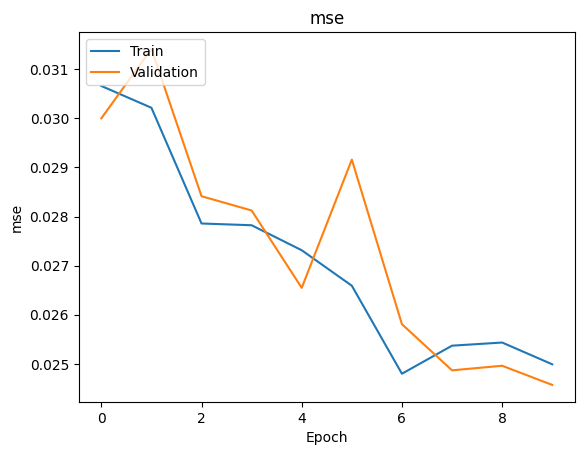

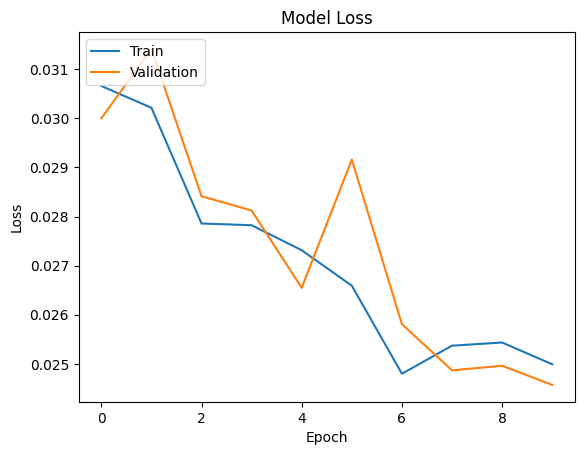

<Figure size 640x480 with 0 Axes>

In [60]:
# Train the model
history = unet.fit(train_images_dataset, epochs=10, validation_data=val_images_dataset)

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc1.png')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('loss1.png')


# Testing the model


In [2]:

test_image_list = list(test_images_only)
test_image = test_image_list[10]
test_feed = tf.stack([fixed_image, test_image],-1)
test_feed = tf.expand_dims(test_feed, axis=0)
results = unet.predict(test_feed)

# displacement_model = tf.keras.Model(inputs=unet.input,
#                                  outputs=unet.get_layer('disp').output)
# displacement_model_output = displacement_model.predict(test_feed)
# prova = tfa.image.dense_image_warp(test_image, displacement_model_output)

# results = unet.predict(test_feed)
predicted_image = results[0, :, :, 0]  # Extract the 2D image from the batch


fig, axs = plt.subplots(1, 4, figsize=(15, 15))  # Adjust the figsize as needed

axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title('fixed image')

axs[1].imshow(test_image, cmap = 'gray')
axs[1].set_title('moving image')

axs[2].imshow(predicted_image, cmap= 'gray')
axs[2].set_title('deformed image')

axs[3].imshow(fixed_image,cmap='gray')
axs[3].imshow(predicted_image, alpha = 0.6)
axs[3].set_title('overlapping image')


NameError: name 'test_images_only' is not defined